In [1]:
import os
os.makedirs('Dataset', exist_ok=True)


In [2]:
! chmod 600 kaggle.json

In [3]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import cv2
import tensorflow as tf
import os , shutil
import skimage
import skimage.segmentation
%matplotlib inline
plt.style.use('ggplot')

In [4]:
kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")


'/kaggle/input/chest-xray-pneumonia'

In [6]:
import numpy as np
import os
import cv2

labels = ['PNEUMONIA', 'NORMAL']
img_size = 128

def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)  # class_num = 0 or 1
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_img = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_img, class_num])
            except Exception as e:
                print(e)
    # Shuffle the data to mix classes
    np.random.shuffle(data)
    # Separate features and labels
    X = []
    y = []
    for features, label in data:
        X.append(features)
        y.append(label)
    X = np.array(X).reshape(-1, img_size, img_size, 1)  # adding channel dimension
    y = np.array(y)
    return X, y


In [7]:
train = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/train")
test = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/test")
val = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/val")

In [8]:
pneumonia = os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pneumonia_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"
normal = os.listdir("/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train/NORMAL"

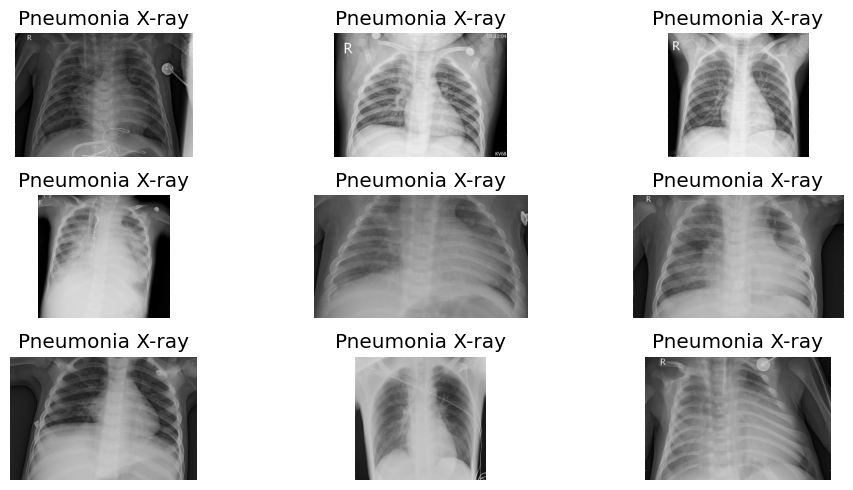

In [9]:
plt.figure(figsize=(10,5))

for i in range(9):
  plt.subplot(3,3,i+1)
  img = plt.imread(os.path.join(pneumonia_dir , pneumonia[i]))
  plt.imshow(img , cmap='gray')
  plt.axis('off')
  plt.title('Pneumonia X-ray')
plt.tight_layout()
plt.show()

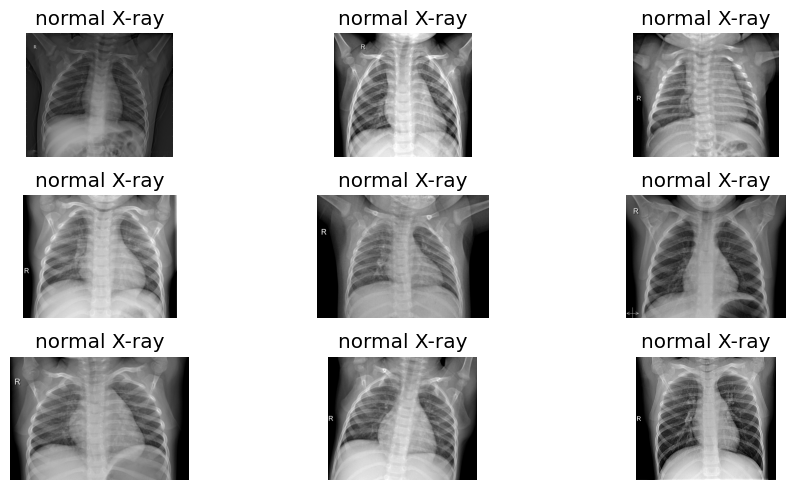

In [10]:
plt.figure(figsize=(10,5))

for i in range(9):
  plt.subplot(3,3,i+1)
  img = plt.imread(os.path.join(normal_dir , normal[i]))
  plt.imshow(img , cmap='gray')
  plt.axis('off')
  plt.title('normal X-ray')
plt.tight_layout()
plt.show()

In [11]:
train_X, train_y = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/train")

<Axes: xlabel='count'>

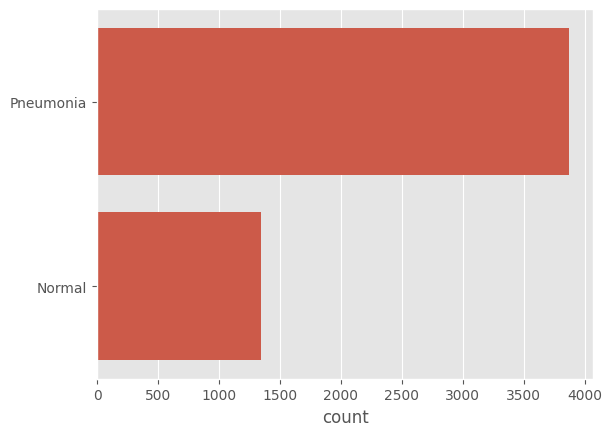

In [12]:
listx = []
for label in train_y:
    if label == 0:
        listx.append("Pneumonia")
    else:
        listx.append("Normal")
sns.countplot(listx)


In [13]:
test_X, test_y = get_data("/kaggle/input/chest-xray-pneumonia/chest_xray/test")

<Axes: xlabel='count'>

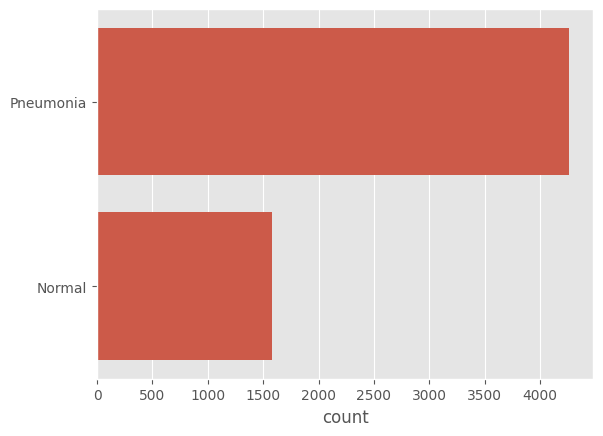

In [14]:
listtest = []
for label in test_y:
    if label == 0:
        listx.append("Pneumonia")
    else:
        listx.append("Normal")
sns.countplot(listx)

Data Augmentation & Resizing

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input , Dense , Flatten , MaxPooling2D , Conv2D , Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint ,ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
import math
from tensorflow.keras.layers import BatchNormalization

In [16]:
train_datagen = ImageDataGenerator(rescale=1. /255 ,
                  horizontal_flip = 0.4 ,
                   vertical_flip = 0.4 ,
                   rotation_range = 40 ,
                   shear_range = 0.2,
                   width_shift_range = 0.4 ,
                   height_shift_range = 0.4,
                   fill_mode = "nearest")

valid_datagen = ImageDataGenerator(rescale=1. /255)
test_datagen = ImageDataGenerator(rescale=1. /255)



In [17]:
train_genaretor = train_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/train" ,
                                  batch_size = 32,
                                  target_size = (128,128),
                                  class_mode = "categorical" ,
                                  shuffle = True,
                                  seed = 42 ,
                                  color_mode = "rgb")
valid_genaretor = valid_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/val" ,
                                  batch_size = 32,
                                  target_size = (128,128),
                                  class_mode = "categorical" ,
                                  shuffle = True,
                                  seed = 42 ,
                                  color_mode = "rgb")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [18]:
class_leabels = train_genaretor.class_indices

In [19]:
class_name = {value : key for (key , value) in class_leabels.items()}

In [20]:
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [21]:
base_model = VGG19(input_shape=(128,128,3),include_top=False,weights='imagenet')

for layers in base_model.layers:
  layers.trainable = False

X = base_model.output
Flat = Flatten()(X)

class1 = Dense(4608 , activation='relu')(Flat)
class1 = BatchNormalization()(class1)
dropout = Dropout(0.2)(class1)
class2 = Dense(1152 , activation='relu')(dropout)
class2 = BatchNormalization()(class2)
output = Dense(2 , activation='softmax')(class2)

model01 = Model(inputs=base_model.input , outputs=output)
model01.summary()



80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4608)           │        18,43

 Total params: 63,112,642 (240.76 MB)

 Trainable params: 43,076,738 (164.32 MB)

 Non-trainable params: 20,035,904 (76.43 MB)

In [22]:
filepath="model.h5"
ES = EarlyStopping(monitor="val_loss" , verbose=1 , patience=4 , mode="min")
CP = ModelCheckpoint(filepath , monitor="val_loss", save_best_only=True ,
                                  save_weights_only=False , mode="auto", save_freq="epoch")

lrr = ReduceLROnPlateau(monitor="val_accuracy" , patience=3 , verbose=1 , factor= 0.5, min_lr=0.0001)
sgd = SGD(learning_rate=0.0001 , decay = 1e-6 , momentum=0.001 , nesterov= True)

model01.compile(loss="categorical_crossentropy" , optimizer=sgd , metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [23]:
history01 = model01.fit(train_genaretor ,
            steps_per_epoch = 50 ,
            epochs = 40 ,
            callbacks = [ES , CP , lrr],
            validation_data =valid_genaretor )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.5261 - loss: 1.0312

50/50 ━━━━━━━━━━━━━━━━━━━━ 38s 570ms/step - accuracy: 0.5267 - loss: 1.0298 - val_accuracy: 0.6250 - val_loss: 0.6249 - learning_rate: 1.0000e-04
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.6422 - loss: 0.7800

50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 609ms/step - accuracy: 0.6425 - loss: 0.7793 - val_accuracy: 0.8125 - val_loss: 0.5256 - learning_rate: 1.0000e-04
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.6477 - loss: 0.7243

50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 500ms/step - accuracy: 0.6481 - loss: 0.7240 - val_accuracy: 0.8750 - val_loss: 0.4413 - learning_rate: 1.0000e-04
Epoch 4/40
13/50 ━━━━━━━━━━━━━━━━━━━━ 13s 375ms/step - accuracy: 0.6477 - loss: 0.8513

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 216ms/step - accuracy: 0.6718 - loss: 0.7998 - val_accuracy: 0.9375 - val_loss: 0.4232 - learning_rate: 1.0000e-04
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step - accuracy: 0.7147 - loss: 0.6365

50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 611ms/step - accuracy: 0.7146 - loss: 0.6368 - val_accuracy: 0.8750 - val_loss: 0.3672 - learning_rate: 1.0000e-04
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.7343 - loss: 0.6299

50/50 ━━━━━━━━━━━━━━━━━━━━ 32s 657ms/step - accuracy: 0.7341 - loss: 0.6303 - val_accuracy: 0.8750 - val_loss: 0.3199 - learning_rate: 1.0000e-04
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7320 - loss: 0.6633

50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 590ms/step - accuracy: 0.7320 - loss: 0.6631 - val_accuracy: 0.8750 - val_loss: 0.2952 - learning_rate: 1.0000e-04
Epoch 8/40
13/50 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.7247 - loss: 0.5800

50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - accuracy: 0.7327 - loss: 0.5962 - val_accuracy: 0.9375 - val_loss: 0.2867 - learning_rate: 1.0000e-04
Epoch 9/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.6973 - loss: 0.6837

50/50 ━━━━━━━━━━━━━━━━━━━━ 78s 751ms/step - accuracy: 0.6977 - loss: 0.6834 - val_accuracy: 0.8750 - val_loss: 0.2592 - learning_rate: 1.0000e-04
Epoch 10/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.7166 - loss: 0.6819

50/50 ━━━━━━━━━━━━━━━━━━━━ 33s 666ms/step - accuracy: 0.7167 - loss: 0.6814 - val_accuracy: 0.8750 - val_loss: 0.2451 - learning_rate: 1.0000e-04
Epoch 11/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.7514 - loss: 0.5758

50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 552ms/step - accuracy: 0.7515 - loss: 0.5758 - val_accuracy: 0.8750 - val_loss: 0.2430 - learning_rate: 1.0000e-04
Epoch 12/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.7738 - loss: 0.5643 - val_accuracy: 0.8750 - val_loss: 0.2464 - learning_rate: 1.0000e-04
Epoch 13/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.7624 - loss: 0.5979

50/50 ━━━━━━━━━━━━━━━━━━━━ 72s 593ms/step - accuracy: 0.7623 - loss: 0.5974 - val_accuracy: 0.8750 - val_loss: 0.2304 - learning_rate: 1.0000e-04
Epoch 14/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 426ms/step - accuracy: 0.7559 - loss: 0.6111 - val_accuracy: 0.8750 - val_loss: 0.2385 - learning_rate: 1.0000e-04
Epoch 15/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 451ms/step - accuracy: 0.7886 - loss: 0.5263 - val_accuracy: 0.8750 - val_loss: 0.2689 - learning_rate: 1.0000e-04
Epoch 16/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.7426 - loss: 0.6253 - val_accuracy: 0.8750 - val_loss: 0.2638 - learning_rate: 1.0000e-04
Epoch 17/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 457ms/step - accuracy: 0.7577 - loss: 0.5666 - val_accuracy: 0.8750 - val_loss: 0.2676 - learning_rate: 1.0000e-04
Epoch 17: early stopping


In [27]:
model01.save('model03.h5' , overwrite= True)  # Save architecture + weights + optimizer

from google.colab import files
files.download('model03.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [25]:
test_genaretor = test_datagen.flow_from_directory("/kaggle/input/chest-xray-pneumonia/chest_xray/test" ,
                                  batch_size = 32,
                                  target_size = (128,128),
                                  class_mode = "categorical" ,
                                  shuffle = True,
                                  seed = 42 ,
                                  color_mode = "rgb")

Found 624 images belonging to 2 classes.


In [28]:
model01.load_weights("model03.h5")

vgg_val_eval01 = model01.evaluate(valid_genaretor)
vgg_test_eval01 = model01.evaluate(test_genaretor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8750 - loss: 0.2676
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 251ms/step - accuracy: 0.7813 - loss: 0.4724


In [30]:
print(f"Validation Accuracy: {vgg_val_eval01[1]}")
print(f"Test Accuracy: {vgg_test_eval01[1] }")
print(f"Validation loss: {vgg_val_eval01[0]}")
print(f"Test loss: {vgg_test_eval01[0] }")

Validation Accuracy: 0.875
Test Accuracy: 0.7980769276618958
Validation loss: 0.26758599281311035
Test loss: 0.453673392534256


#Incremental unfreezing & fine tuning


In [31]:
base_model = VGG19(input_shape=(128,128,3),
                   include_top=False)

base_model_layer_names = [layer.name for layer in base_model.layers]

In [32]:
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [33]:
X = base_model.output
Flat = Flatten()(X)

class1 = Dense(4608 , activation='relu')(Flat)
class1 = BatchNormalization()(class1)
dropout = Dropout(0.2)(class1)
class2 = Dense(1152 , activation='relu')(dropout)
class2 = BatchNormalization()(class2)
output = Dense(2 , activation='softmax')(class2)

model11 = Model(base_model.input , output)
model11.load_weights("model03.h5")
set_trainable = False

for layer in base_model.layers:
    if layer.name in ['block5_conv3' , 'block5_conv4']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model11.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4608)           │        18,43

 Total params: 63,112,642 (240.76 MB)

 Trainable params: 47,796,354 (182.33 MB)

 Non-trainable params: 15,316,288 (58.43 MB)

In [35]:

sgd = SGD(learning_rate=0.0001 , decay = 1e-6 , momentum=0.001 , nesterov= True)

model11.compile(loss="categorical_crossentropy" , optimizer=sgd , metrics=["accuracy"])

In [36]:
history02 = model11.fit(train_genaretor ,
            steps_per_epoch = 50 ,
            epochs = 20 ,
            callbacks = [ES , CP , lrr],
            validation_data =valid_genaretor )

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.7608 - loss: 0.5444

50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 511ms/step - accuracy: 0.7608 - loss: 0.5444 - val_accuracy: 0.8750 - val_loss: 0.2361 - learning_rate: 1.0000e-04
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 446ms/step - accuracy: 0.7774 - loss: 0.4876 - val_accuracy: 0.8125 - val_loss: 0.3035 - learning_rate: 1.0000e-04
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 470ms/step - accuracy: 0.7572 - loss: 0.5471 - val_accuracy: 0.8750 - val_loss: 0.2754 - learning_rate: 1.0000e-04
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.7665 - loss: 0.5534 - val_accuracy: 0.8750 - val_loss: 0.2437 - learning_rate: 1.0000e-04
Epoch 5/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 455ms/step - accuracy: 0.7645 - loss: 0.5311 - val_accuracy: 0.8750 - val_loss: 0.2391 - learning_rate: 1.0000e-04
Epoch 5: early stopping


In [37]:
model11.save('model11.h5' , overwrite= True)  # Save architecture + weights + optimizer

from google.colab import files
files.download('model11.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
model11.load_weights("model11.h5")

vgg_val_eval11 = model11.evaluate(valid_genaretor)
vgg_test_eval11 = model11.evaluate(test_genaretor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.8750 - loss: 0.2391
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - accuracy: 0.8139 - loss: 0.4156


In [39]:
print(f"Validation Accuracy: {vgg_val_eval11[1]}")
print(f"Test Accuracy: {vgg_test_eval11[1] }")
print(f"Validation loss: {vgg_val_eval11[0]}")
print(f"Test loss: {vgg_test_eval11[0] }")

Validation Accuracy: 0.875
Test Accuracy: 0.8012820482254028
Validation loss: 0.23908555507659912
Test loss: 0.44252756237983704


In [41]:
base_model = VGG19(input_shape=(128,128,3),
                   include_top=False)
X = base_model.output
Flat = Flatten()(X)

class1 = Dense(4608 , activation='relu')(Flat)
class1 = BatchNormalization()(class1)
dropout = Dropout(0.2)(class1)
class2 = Dense(1152 , activation='relu')(dropout)
class2 = BatchNormalization()(class2)
output = Dense(2 , activation='softmax')(class2)

model12 = Model(base_model.input , output)
model12.load_weights("model11.h5")

model12.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4608)           │        18,43

 Total params: 63,112,642 (240.76 MB)

 Trainable params: 63,101,122 (240.71 MB)

 Non-trainable params: 11,520 (45.00 KB)

In [43]:

sgd = SGD(learning_rate=0.0001 , decay = 1e-6 , momentum=0.001 , nesterov= True)

model12.compile(loss="categorical_crossentropy" , optimizer=sgd , metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [44]:
history03 = model12.fit(train_genaretor ,
            steps_per_epoch = 100 ,
            epochs = 20 ,
            callbacks = [ES , CP , lrr],
            validation_data =valid_genaretor )

Epoch 1/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 73s 509ms/step - accuracy: 0.7734 - loss: 0.5325 - val_accuracy: 0.8750 - val_loss: 0.2580 - learning_rate: 1.0000e-04
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - accuracy: 0.7859 - loss: 0.5317 - val_accuracy: 0.8750 - val_loss: 0.2450 - learning_rate: 1.0000e-04
Epoch 3/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


100/100 ━━━━━━━━━━━━━━━━━━━━ 91s 485ms/step - accuracy: 0.8036 - loss: 0.4834 - val_accuracy: 0.8125 - val_loss: 0.3462 - learning_rate: 1.0000e-04
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 31s 309ms/step - accuracy: 0.8143 - loss: 0.4631 - val_accuracy: 0.8125 - val_loss: 0.4730 - learning_rate: 1.0000e-04
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 49s 485ms/step - accuracy: 0.8247 - loss: 0.4496 - val_accuracy: 0.8125 - val_loss: 0.3959 - learning_rate: 1.0000e-04
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 302ms/step - accuracy: 0.8335 - loss: 0.4197 - val_accuracy: 0.8750 - val_loss: 0.3520 - learning_rate: 1.0000e-04
Epoch 6: early stopping


In [45]:
model11.save('model12.h5' , overwrite= True)  # Save architecture + weights + optimizer

from google.colab import files
files.download('model12.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
model11.load_weights("model12.h5")

vgg_val_eval12 = model12.evaluate(valid_genaretor)
vgg_test_eval12 = model12.evaluate(test_genaretor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8750 - loss: 0.3520
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.8382 - loss: 0.4357


In [47]:
print(f"Validation Accuracy: {vgg_val_eval12[1]}")
print(f"Test Accuracy: {vgg_test_eval12[1] }")
print(f"Validation loss: {vgg_val_eval12[0]}")
print(f"Test loss: {vgg_test_eval12[0] }")

Validation Accuracy: 0.875
Test Accuracy: 0.8429487347602844
Validation loss: 0.3520163297653198
Test loss: 0.40127724409103394


In [49]:
base_model = VGG19(input_shape=(128,128,3),
                   include_top=False)
X = base_model.output
Flat = Flatten()(X)

class1 = Dense(4608 , activation='relu')(Flat)
class1 = BatchNormalization()(class1)
dropout = Dropout(0.2)(class1)
class2 = Dense(1152 , activation='relu')(dropout)
class2 = BatchNormalization()(class2)
output = Dense(2 , activation='softmax')(class2)

model13 = Model(base_model.input , output)
model13.load_weights("model12.h5")

model13.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4608)           │    37,753,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 4608)           │        18,43

 Total params: 63,112,642 (240.76 MB)

 Trainable params: 63,101,122 (240.71 MB)

 Non-trainable params: 11,520 (45.00 KB)

In [50]:
sgd = SGD(learning_rate=0.0001 , decay = 1e-6 , momentum=0.001 , nesterov= True)

model13.compile(loss="categorical_crossentropy" , optimizer=sgd , metrics=["accuracy"])

/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [51]:
history04 = model13.fit(train_genaretor ,
            steps_per_epoch = 500 ,
            epochs = 20 ,
            callbacks = [ES , CP , lrr],
            validation_data =valid_genaretor )

Epoch 1/20
163/500 ━━━━━━━━━━━━━━━━━━━━ 2:50 507ms/step - accuracy: 0.7814 - loss: 0.5239

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


500/500 ━━━━━━━━━━━━━━━━━━━━ 96s 178ms/step - accuracy: 0.7938 - loss: 0.5060 - val_accuracy: 0.8750 - val_loss: 0.2191 - learning_rate: 1.0000e-04
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 130s 160ms/step - accuracy: 0.8120 - loss: 0.4758 - val_accuracy: 0.8125 - val_loss: 0.4543 - learning_rate: 1.0000e-04
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 158ms/step - accuracy: 0.8312 - loss: 0.4430 - val_accuracy: 0.8125 - val_loss: 0.5349 - learning_rate: 1.0000e-04
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 160ms/step - accuracy: 0.8566 - loss: 0.3912 - val_accuracy: 0.8125 - val_loss: 0.5207 - learning_rate: 1.0000e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 157ms/step - accuracy: 0.8638 - loss: 0.3855 - val_accuracy: 0.7500 - val_loss: 0.5500 - learning_rate: 1.0000e-04
Epoch 5: early stopping


In [52]:
model11.save('model13.h5' , overwrite= True)  # Save architecture + weights + optimizer

from google.colab import files
files.download('model13.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [53]:
model13.load_weights("model13.h5")

vgg_val_eval13 = model13.evaluate(valid_genaretor)
vgg_test_eval13 = model13.evaluate(test_genaretor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.8750 - loss: 0.2391
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.8017 - loss: 0.4536


In [55]:
print(f"Validation Accuracy: {vgg_val_eval13[1]}")
print(f"Test Accuracy: {vgg_test_eval13[1] }")
print(f"Validation loss: {vgg_val_eval13[0]}")
print(f"Test loss: {vgg_test_eval13[0] }")

Validation Accuracy: 0.875
Test Accuracy: 0.8012820482254028
Validation loss: 0.23908555507659912
Test loss: 0.44252756237983704
